<a href="https://colab.research.google.com/github/me-t1me/Bilateral_relation_paper/blob/master/Bilateral_relation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_white
import pandas_datareader as pdr
import datetime
import re

In [2]:
# to use data with sentiment of year before funding
lagging = True
# to remove data of indian investors
remove_indian_investors = True

# Data cleaning and processing
returns data: cleaned and processed pandas dataframe


In [3]:

if lagging:
  df = pd.read_excel("https://github.com/me-t1me/Bilateral_relation_paper/blob/master/Data_relations_with_lagging_sentiment.xlsx?raw=true")
else:
  df = pd.read_excel("https://github.com/me-t1me/Bilateral_relation_paper/blob/master/Data_relation.xlsx?raw=true")

In [4]:
if remove_indian_investors:
  df = df[df['Sentiment'] != 1]

In [5]:
df.head()

,Company,Company Type,Industry,Sector,Amount(US$M),Amount(INR Cr),Round,Stage,Investors,Investor Type,...,Valuation,Revenue (INR Cr),EBITDA (INR Cr),PAT (INR Cr),Total Debt (INR Cr),Cash & Cash Equ. (INR Cr),Book Value Per Share,Price Per Share,Link for Financials,Sentiment
6262,Arya Collateral,Unlisted,Agri-business,Agri Logistics,21.00,NaN,NaN,Late,"Quona Capital, LGT Lightstone Aspada, Omnivore...",Co-Investment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159755
6263,Azooka Life Sciences,Unlisted,Healthcare & Life Sciences,Biotech,NaN,NaN,Seed,Early,Honeywell Ventures,Foreign,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159755
6264,boAt,Unlisted,IT & ITES,IT Products (Hardware - Consumer Electronics),100.00,731.0,2,Early,Warburg Pincus,India-dedicated,...,Valuation Multiples are based on FY19 Financials.,240.74,14.45,8.73,14.49,0.02,NaN,283749,NaN,0.159755
6265,Chenani Nashri Tunnelway,Unlisted,Engg. & Construction,Infrastructure (Roads),527.96,3900.0,NaN,Buyout-Large,"I Squared Capital, IFC",Foreign,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159755
6266,CoinDCX,Unlisted,IT & ITES,Online Services (Payments - Cryptocurrency),13.90,100.0,2,Early,"Polychain Capital, Coinbase Ventures, Others",Co-Investment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159755


In [6]:
needed_col = ['Industry', 'Amount(US$M)', 'Stage', 'Investor Type', 'Date', 'Year Founded', 'State', 'Post Money Valuation (INR Cr)', 'Sentiment', 'Region']

In [7]:
regdata = df.loc[:, needed_col]

In [8]:
regdata = regdata.dropna()

In [9]:
len(regdata)

4140

In [10]:
regdata = regdata[regdata['Amount(US$M)'] != 0] 
regdata['funding'] = np.log(regdata['Amount(US$M)'])

In [11]:
regdata['Year'] = pd.to_datetime(regdata['Date'], format='%b-%y').dt.year

In [12]:
def remove_bad(x):
  try:
    return int(x)
  except:
    return 0

In [13]:
regdata['Year Founded'] = regdata['Year Founded'].apply(remove_bad)

In [14]:
regdata['Year Founded'].unique()

array([2013, 2018, 2011, 2007, 2019, 1984, 2016, 2015, 2006, 2020, 2012,
       2017, 1999, 2014, 2008, 2010, 1993, 2002, 2009, 1992, 1972, 1987,
       2004, 1990, 2000, 1971, 1994, 2001, 1996, 1995, 1982, 1988, 1989,
       1985, 1998, 1980, 1986, 2003, 1969, 2005, 1997, 1983, 1916, 1930,
       1929, 1991, 1979, 1970, 1981, 1978, 1951, 1945, 1973, 1947, 1943,
       1920, 1963, 1955, 1976, 1935,    0, 1961, 1952, 1875, 1974, 1917,
       1966, 1975, 1977, 1960, 1967, 1924, 1938, 1826, 1939, 1937, 1959,
       1962, 1944, 1964, 1884, 1905, 1881, 1019, 1946, 1957])

In [15]:
regdata['age'] = regdata['Year'].astype(np.int32) - regdata['Year Founded'].astype(np.int32) + 1

In [16]:
regdata = regdata[regdata['age'] > 0]

In [17]:
start_date = datetime.datetime(2004, 1, 1)
end_date = datetime.datetime(2020, 12, 31)
exchange_rates = pdr.DataReader('DEXINUS', 'fred', start_date, end_date)
exchange_rates

,DEXINUS
DATE,
2004-01-01,NaN
2004-01-02,45.68
2004-01-05,45.60
2004-01-06,45.66
2004-01-07,45.53
...,...
2020-12-25,NaN
2020-12-28,73.50
2020-12-29,73.33


In [18]:
exchange_rates = exchange_rates.dropna()

In [19]:
exchange_rates.index = exchange_rates.index.strftime('%b-%y')

In [20]:
exchange_rates = exchange_rates[~exchange_rates.index.duplicated(keep='first')]

In [21]:
regdata['exchange_rates'] = None

In [22]:
for i in regdata.index:
  regdata['exchange_rates'][i] = exchange_rates['DEXINUS'][regdata['Date'][i]]

<ipython-input-22-842fbc435bac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regdata['exchange_rates'][i] = exchange_rates['DEXINUS'][regdata['Date'][i]]


In [23]:
def clean_currency(x):
    if isinstance(x, str):
        return(x.replace(',', ''))
    return(x)

In [24]:
regdata['Post Money Valuation (INR Cr)'] = regdata['Post Money Valuation (INR Cr)'].apply(clean_currency).astype('float')

In [25]:
regdata['valuation'] = np.log(((regdata['Post Money Valuation (INR Cr)'] * 10 ) / regdata['exchange_rates']).astype(float))

In [26]:
def get_stage_dummy(x):
  if x == "Early":
    return 1
  
  return 0

In [27]:
def get_growth_dummy(x):
  if x == 'Growth-PE' or x == 'Growth':
    return 1
  else:
    return 0

In [28]:
def get_region_dummy(x):
  if x == 'North':
    return 1
  else:
    return 0

In [29]:
regdata['Early'] = regdata['Stage'].apply(get_stage_dummy)

In [30]:
regdata["growth"] = regdata['Stage'].apply(get_growth_dummy)

In [31]:
regdata["North"] = regdata['Region'].apply(get_region_dummy)

In [32]:
regdata.head()

,Industry,Amount(US$M),Stage,Investor Type,Date,Year Founded,State,Post Money Valuation (INR Cr),Sentiment,Region,funding,Year,age,exchange_rates,valuation,Early,growth,North
6264,IT & ITES,100.0,Early,India-dedicated,Dec-20,2013,Maharashtra,2090.31,0.159755,West,4.605170,2020,8,73.51,5.650231,1,0,0
6267,IT & ITES,81.0,Growth-PE,Co-Investment,Dec-20,2018,Maharashtra,5878.80,0.159755,West,4.394449,2020,3,73.51,6.684272,0,1,0
6268,Education,40.0,Growth-PE,Co-Investment,Dec-20,2011,Karnataka,1263.19,0.159755,South,3.688879,2020,10,73.51,5.146559,0,1,0
6269,IT & ITES,100.0,Late,Co-Investment,Dec-20,2007,Karnataka,7406.10,0.159755,South,4.605170,2020,14,73.51,6.915223,0,0,0
6272,IT & ITES,145.0,Growth-PE,Foreign,Dec-20,2019,Karnataka,7406.10,0.159755,South,4.976734,2020,2,73.51,6.915223,0,1,0


In [33]:
inflation = {	
     2012:	11.17, 
     2011:	6.49 , 
     2020:	3.69 ,
     2010:	9.47 , 
     2019:	9.63 ,
     2009:	14.97,
     2018:	5.24 ,	 	
     2008:	9.70 , 
     2017:	4.00 ,	 	
     2007:	5.51 , 
     2016:	2.23 ,	 	
     2006:	6.53 , 
     2015:	6.32 ,	 	
     2005:	5.57 , 
     2014:	5.86 ,	 	
     2004:	3.78 , 
     2013:	9.13 ,	
    } 

regdata["inflation"] = None
for i in regdata.index:
  regdata["inflation"][i] = np.log(inflation[regdata["Year"][i]]).astype(float)

regdata.head()

<ipython-input-33-27f69ffdc747>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regdata["inflation"][i] = np.log(inflation[regdata["Year"][i]]).astype(float)


,Industry,Amount(US$M),Stage,Investor Type,Date,Year Founded,State,Post Money Valuation (INR Cr),Sentiment,Region,funding,Year,age,exchange_rates,valuation,Early,growth,North,inflation
6264,IT & ITES,100.0,Early,India-dedicated,Dec-20,2013,Maharashtra,2090.31,0.159755,West,4.605170,2020,8,73.51,5.650231,1,0,0,1.305626
6267,IT & ITES,81.0,Growth-PE,Co-Investment,Dec-20,2018,Maharashtra,5878.80,0.159755,West,4.394449,2020,3,73.51,6.684272,0,1,0,1.305626
6268,Education,40.0,Growth-PE,Co-Investment,Dec-20,2011,Karnataka,1263.19,0.159755,South,3.688879,2020,10,73.51,5.146559,0,1,0,1.305626
6269,IT & ITES,100.0,Late,Co-Investment,Dec-20,2007,Karnataka,7406.10,0.159755,South,4.605170,2020,14,73.51,6.915223,0,0,0,1.305626
6272,IT & ITES,145.0,Growth-PE,Foreign,Dec-20,2019,Karnataka,7406.10,0.159755,South,4.976734,2020,2,73.51,6.915223,0,1,0,1.305626


In [34]:
# import yfinance as yf
# from datetime import date
# import pandas as pd

# start_date = date(2004, 1, 1)
# end_date = date(2020, 12, 31)
# nifty_data = yf.Ticker("^NSEI").history( start=start_date, end=end_date)
# nifty_data['Market Cap'] = nifty_data['Close'] * nifty_data['Volume']

# nifty_data.index = pd.to_datetime(nifty_data.index, format='%Y-%m-%d')

# nifty_monthly = nifty_data.resample('M')['Market Cap'].sum()

# nifty_monthly.index = nifty_monthly.index.strftime('%b-%y')

In [35]:
regdata['Date'].unique()

array(['Dec-20', 'Nov-20', 'Oct-20', 'Sep-20', 'Aug-20', 'Jul-20',
       'Jun-20', 'May-20', 'Apr-20', 'Mar-20', 'Feb-20', 'Jan-20',
       'Dec-19', 'Nov-19', 'Oct-19', 'Sep-19', 'Aug-19', 'Jul-19',
       'Jun-19', 'May-19', 'Apr-19', 'Mar-19', 'Feb-19', 'Jan-19',
       'Dec-18', 'Nov-18', 'Oct-18', 'Sep-18', 'Aug-18', 'Jul-18',
       'Jun-18', 'May-18', 'Apr-18', 'Mar-18', 'Feb-18', 'Jan-18',
       'Dec-17', 'Nov-17', 'Oct-17', 'Sep-17', 'Aug-17', 'Jul-17',
       'Jun-17', 'May-17', 'Apr-17', 'Mar-17', 'Feb-17', 'Jan-17',
       'Dec-16', 'Nov-16', 'Oct-16', 'Sep-16', 'Aug-16', 'Jul-16',
       'Jun-16', 'May-16', 'Apr-16', 'Mar-16', 'Feb-16', 'Jan-16',
       'Dec-15', 'Nov-15', 'Oct-15', 'Sep-15', 'Aug-15', 'Jul-15',
       'Jun-15', 'May-15', 'Apr-15', 'Mar-15', 'Feb-15', 'Jan-15',
       'Dec-14', 'Nov-14', 'Oct-14', 'Sep-14', 'Aug-14', 'Jul-14',
       'Jun-14', 'May-14', 'Apr-14', 'Mar-14', 'Feb-14', 'Jan-14',
       'Dec-13', 'Nov-13', 'Oct-13', 'Sep-13', 'Aug-13', 'Jul-

In [36]:
def format_volume(x):
  try:
    x = x[:-1].replace(',','')
    return float(x)*1000
  except:
    return x*1000

def format_price(x):
  try:
    x = x.replace(',','')
    return float(x)
  except:
    return x

In [37]:
# # Define the start and end dates
# start_date = date(2004, 1, 1)
# end_date = date(2020, 12, 31)

nifty_data = pd.read_csv("https://raw.githubusercontent.com/me-t1me/Bilateral_relation_paper/master/Nifty%2050%20Historical%20Data.csv")
# # Calculate the market capitalization for each day
nifty_data['Vol.'] = nifty_data['Vol.'].apply(format_volume)
nifty_data['Price'] = nifty_data['Price'].apply(format_price)

nifty_data['Market Cap'] = nifty_data['Price'] * nifty_data['Vol.']

nifty_data.index = pd.to_datetime(nifty_data["Date"], format='%m/%d/%Y')

nifty_monthly = nifty_data.resample('M')['Market Cap'].sum()

nifty_monthly.index = nifty_monthly.index.strftime('%b-%y')

In [38]:
regdata['mkt_cap'] = None

for i in regdata.index:
  date = regdata['Date'][i]
  ex = exchange_rates['DEXINUS'][date]
  regdata['mkt_cap'][i] = np.log(nifty_monthly[date] / (ex *  1000000))

<ipython-input-38-97fa81d3b4ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regdata['mkt_cap'][i] = np.log(nifty_monthly[date] / (ex *  1000000))


In [39]:
regdata = regdata[regdata['Investor Type'] != 'Unknown']

In [40]:
data = pd.get_dummies(regdata, columns=['Investor Type', 'State', 'Industry', 'Date']) 

In [41]:
data.drop(columns=['Amount(US$M)', 'Stage', 'Year Founded', 'Post Money Valuation (INR Cr)', 'Year', 'exchange_rates', 'Region'], inplace=True)

In [42]:
data.reset_index(drop=True, inplace=True)

# Regression

In [43]:
data.head()

,Sentiment,funding,age,valuation,Early,growth,North,inflation,mkt_cap,Investor Type_Co-Investment,...,Date_Sep-11,Date_Sep-12,Date_Sep-13,Date_Sep-14,Date_Sep-15,Date_Sep-16,Date_Sep-17,Date_Sep-18,Date_Sep-19,Date_Sep-20
0,0.159755,4.605170,8,5.650231,1,0,0,1.305626,7.704974,0,...,0,0,0,0,0,0,0,0,0,0
1,0.159755,4.394449,3,6.684272,0,1,0,1.305626,7.704974,1,...,0,0,0,0,0,0,0,0,0,0
2,0.159755,3.688879,10,5.146559,0,1,0,1.305626,7.704974,1,...,0,0,0,0,0,0,0,0,0,0
3,0.159755,4.605170,14,6.915223,0,0,0,1.305626,7.704974,1,...,0,0,0,0,0,0,0,0,0,0
4,0.159755,4.976734,2,6.915223,0,1,0,1.305626,7.704974,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
data.describe()

,Sentiment,funding,age,valuation,Early,growth,North,Investor Type_Co-Investment,Investor Type_Foreign,Investor Type_India-dedicated,...,Date_Sep-11,Date_Sep-12,Date_Sep-13,Date_Sep-14,Date_Sep-15,Date_Sep-16,Date_Sep-17,Date_Sep-18,Date_Sep-19,Date_Sep-20
count,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,...,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000
mean,0.247631,2.175809,15.655356,4.017500,0.310470,0.318226,0.268056,0.347552,0.423413,0.229035,...,0.005817,0.004847,0.004605,0.004363,0.008968,0.004120,0.003878,0.011876,0.008483,0.003878
std,0.291871,1.806831,90.435456,1.886330,0.462742,0.465844,0.443001,0.476251,0.494159,0.420263,...,0.076055,0.069462,0.067712,0.065914,0.094283,0.064064,0.062159,0.108341,0.091722,0.062159
min,-0.999244,-3.912023,1.000000,-1.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.177950,0.993252,4.000000,2.682641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.238732,2.203317,7.000000,3.940711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.330445,3.305969,14.000000,5.287061,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.998675,9.197400,2019.000000,11.079346,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Correlation

In [45]:
data['Sentiment'].describe(), data['funding'].describe()

(count    4126.000000
 mean        0.247631
 std         0.291871
 min        -0.999244
 25%         0.177950
 50%         0.238732
 75%         0.330445
 max         0.998675
 Name: Sentiment, dtype: float64,
 count    4126.000000
 mean        2.175809
 std         1.806831
 min        -3.912023
 25%         0.993252
 50%         2.203317
 75%         3.305969
 max         9.197400
 Name: funding, dtype: float64)

In [46]:
corr_mat = data[['Sentiment', 'funding']].corr()
corr_mat

,Sentiment,funding
Sentiment,1.000000,-0.039808
funding,-0.039808,1.000000


<Axes: xlabel='Sentiment', ylabel='funding'>

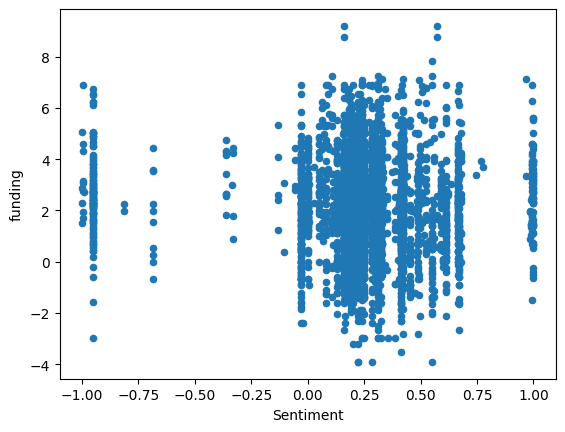

In [47]:
data.plot.scatter(x='Sentiment', y='funding')  # Create scatter plot

In [48]:
data1 = data[data['Sentiment'] != 1]

In [49]:
corr_mat1 = data1[['Sentiment', 'funding']].corr()
corr_mat1 

,Sentiment,funding
Sentiment,1.000000,-0.039808
funding,-0.039808,1.000000


<Axes: xlabel='Sentiment', ylabel='funding'>

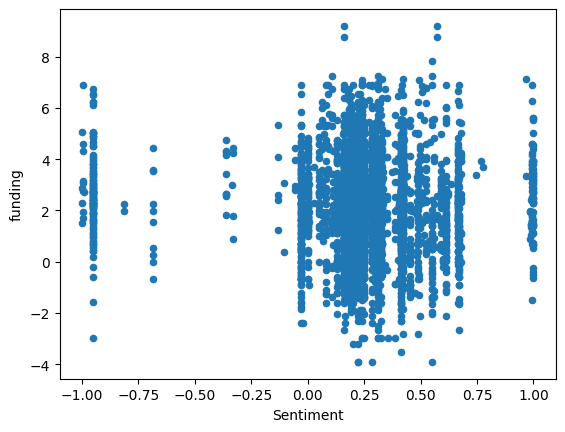

In [50]:
data1.plot.scatter(x='Sentiment', y='funding')

## First Table


### 1st column
X = Sentiment

Y = funding


In [51]:
X, Y = data['Sentiment'], data['funding']

In [52]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.546
Date:                Mon, 17 Apr 2023   Prob (F-statistic):             0.0105
Time:                        07:14:31   Log-Likelihood:                -8291.6
No. Observations:                4126   AIC:                         1.659e+04
Df Residuals:                    4124   BIC:                         1.660e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2368      0.037     60.675      0.0

### 2nd column
X = Sentiment, state, industry, time

Y = funding

In [53]:
X = data.drop(['funding', 'age', 'valuation','Early','inflation','mkt_cap','Investor Type_Co-Investment','Investor Type_Foreign','Investor Type_India-dedicated', 'growth', 'North'], axis = 1)
Y = data["funding"]

In [54]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     2.963
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           7.91e-44
Time:                        07:14:31   Log-Likelihood:                -7936.9
No. Observations:                4126   AIC:                         1.637e+04
Df Residuals:                    3877   BIC:                         1.795e+04
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### 3rd column
X = Sentiment, state, industry, time, age, mkt_cap, inflation, early, valuation

Y = funding

In [55]:
X = data.drop(['funding', 'growth', 'North'], axis=1)
Y = data["funding"]

In [56]:
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype(float)).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     47.93
Date:                Mon, 17 Apr 2023   Prob (F-statistic):               0.00
Time:                        07:14:32   Log-Likelihood:                -5368.0
No. Observations:                4126   AIC:                         1.124e+04
Df Residuals:                    3872   BIC:                         1.285e+04
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

# Regression 2 (after midsem)

## Part 1 
X = Sentiment * Early

Y = Funding 

In [57]:
# making column for Sentiment*Early
data['Sentiment*Early'] = data['Sentiment']*data['Early']
X = data['Sentiment*Early']
Y = data['funding']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     784.4
Date:                Mon, 17 Apr 2023   Prob (F-statistic):          3.58e-158
Time:                        07:14:32   Log-Likelihood:                -7935.6
No. Observations:                4126   AIC:                         1.588e+04
Df Residuals:                    4124   BIC:                         1.589e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.5240      0.029     

## Part 2
X = Early, Sentiment*growth

Y = funding

In [58]:
data["Sentiment*growth"] = data["Sentiment"]*data["growth"]
X = data[["Early", "Sentiment*growth"]]
Y = data["funding"]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     842.7
Date:                Mon, 17 Apr 2023   Prob (F-statistic):          1.40e-307
Time:                        07:14:32   Log-Likelihood:                -7587.8
No. Observations:                4126   AIC:                         1.518e+04
Df Residuals:                    4123   BIC:                         1.520e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.8903      0.032  

## Part 3
X = Sentiment*North

Y = funding

In [59]:
data["Sentiment*North"] = data["Sentiment"]*data["North"]
X = data['Sentiment*North']
Y = data['funding']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.202
Date:                Mon, 17 Apr 2023   Prob (F-statistic):              0.273
Time:                        07:14:32   Log-Likelihood:                -8294.3
No. Observations:                4126   AIC:                         1.659e+04
Df Residuals:                    4124   BIC:                         1.661e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.1861      0.030     

## Part 4
X = Sentiment, state, industry, Year, age, mkt_cap, inflation, early, valuation

Y = funding

In [62]:
data_reg4 = pd.get_dummies(regdata, columns=['Investor Type', 'State', 'Industry', 'Year']) 
data_reg4.drop(columns=['Amount(US$M)', 'Stage', 'Year Founded', 'Post Money Valuation (INR Cr)', 'exchange_rates', 'Region', 'Date', 'North'], inplace=True)
data_reg4.reset_index(drop=True, inplace=True)

In [63]:
X = data_reg4.drop("funding", axis=1)
Y = data_reg4["funding"]
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype(float)).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                funding   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     172.0
Date:                Mon, 17 Apr 2023   Prob (F-statistic):               0.00
Time:                        07:16:40   Log-Likelihood:                -5495.9
No. Observations:                4126   AIC:                         1.113e+04
Df Residuals:                    4057   BIC:                         1.157e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co